# **RTMO**

[just_dance source](https://github.com/open-mmlab/mmpose/tree/main/projects/just_dance)

In [4]:
from moviepy.editor import VideoFileClip

def split_video_vertically(input_video_path, output_left_path, output_right_path, start_frame, end_frame):
    # Загружаем видео
    video = VideoFileClip(input_video_path)

    # Получаем количество кадров в секунду
    fps = video.fps

    # Вычисляем временные метки в секундах
    start_time = start_frame / fps
    end_time = end_frame / fps

    # Извлекаем нужный фрагмент видео
    video_segment = video.subclip(start_time, end_time)

    # Получаем ширину и высоту видео
    width, height = video_segment.size

    # Определяем левые и правые половины
    left_half = video_segment.crop(x1=0, y1=0, x2=width // 2, y2=height)
    right_half = video_segment.crop(x1=width // 2, y1=0, x2=width, y2=height)

    # Сохраняем результаты
    left_half.write_videofile(output_left_path, codec='libx264')
    right_half.write_videofile(output_right_path, codec='libx264')

# Пример использования
input_video = "/content/TikTok_Dance.mp4"  # Путь к входному видео
output_left = "/content/left_half.mp4"     # Путь для сохранения левой половины
output_right = "/content/right_half.mp4"   # Путь для сохранения правой половины

# Задаем кадры, которые нужно извлечь
start_frame = 50
end_frame = 366

split_video_vertically(input_video, output_left, output_right, start_frame, end_frame)

  if event.key is 'enter':



Moviepy - Building video /content/left_half.mp4.
MoviePy - Writing audio in left_halfTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/left_half.mp4



Moviepy - Done !
Moviepy - video ready /content/left_half.mp4
Moviepy - Building video /content/right_half.mp4.
MoviePy - Writing audio in right_halfTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/right_half.mp4



Moviepy - Done !
Moviepy - video ready /content/right_half.mp4


In [2]:
!pip install mmcv==2.1.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.4/471.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.3/452.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.2 MB/s eta 0:00:00


In [6]:
!pip install mmpose -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.0/436.0 kB 20.3 MB/s eta 0:00:00


In [7]:
!pip install mmdet -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.5 MB/s eta 0:00:00


In [8]:
!mkdir configs
!mv rtmdet-nano_one-person.py configs/
!mv rtmdet_nano_320-8xb32_coco-person.py configs/

In [11]:
!python process_video.py /content/right_half.mp4 /content/left_half.mp4

/usr/local/lib/python3.10/dist-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-tiny_simcc-aic-coco_pt-aic-coco_420e-256x192-cfc8f33d_20230126.pth
10/20 17:11:28 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used t

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from collections import OrderedDict
from tqdm import tqdm

from pose_estimation_modul import show_vectors, get_limbs_from_keypoints
from pose_estimation_modul import cossim, icp, get_vectors

import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

In [3]:
# Загрузка файлов
left_half_kpts = torch.load('just_dance_kpts/left_half_kpts.pth')
right_half_kpts = torch.load('just_dance_kpts/right_half_kpts.pth')

# Просмотр содержимого
print(f"Число временных отрезков: {len(left_half_kpts)}")
print(f"Число kpts: {len(left_half_kpts[0])}")

Число временных отрезков: 316
Число kpts: 17


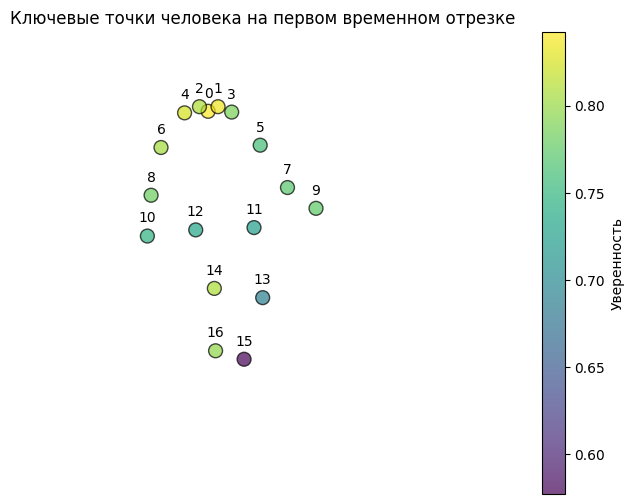

In [4]:
# Получаем ключевые точки для первого временного отрезка
keypoints = left_half_kpts[0]  

# Извлекаем координаты x и y, а также оценки уверенности
x = keypoints[:, 0]
y = keypoints[:, 1]
confidence = keypoints[:, 2]

# Создаем график
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=confidence, cmap='viridis', s=100, alpha=0.7, edgecolors='k')

# Добавляем аннотации для каждой ключевой точки
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.annotate(f'{i}', (x_coord, y_coord), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Ключевые точки человека на первом временном отрезке')
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.colorbar(label='Уверенность')
plt.xlim(0, 200)
plt.ylim(0, 300)
plt.gca().invert_yaxis()
plt.grid()
plt.axis('off')
plt.show()

In [7]:
coco_keypoints = [
    'nose','left_eye','right_eye',
    'left_ear','right_ear','left_shoulder',
    'right_shoulder','left_elbow','right_elbow',
    'left_wrist','right_wrist','left_hip',
    'right_hip','left_knee', 'right_knee', 
    'left_ankle','right_ankle'
]

limbs = get_limbs_from_keypoints(coco_keypoints)

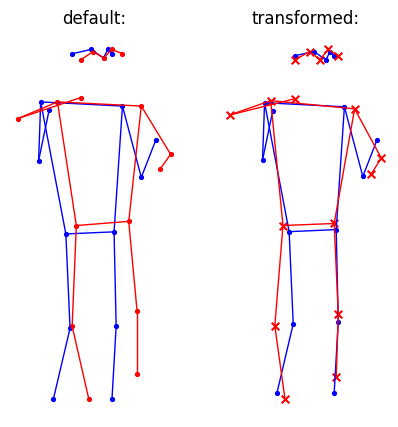

In [12]:
IDX = 160
left_vectors = get_vectors(left_half_kpts[IDX], limbs)
transformed_left_points = icp(left_half_kpts[IDX][:, :2], right_half_kpts[IDX][:, :2])
transformed_left_vectors = get_vectors(
    transformed_left_points, limbs
    )
right_vectors = get_vectors(right_half_kpts[IDX], limbs)

# Визуализация исходных и преобразованных данных
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

show_vectors(right_vectors, ax[0])
show_vectors(left_vectors, ax[0], color='r')

show_vectors(right_vectors, ax[1])
show_vectors(transformed_left_vectors, ax[1],
             color='r', marker='x')

# Настройки графика
ax[0].set_title('default:')
ax[1].set_title('transformed:')
ax[0].axis('off')
ax[1].axis('off')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

In [54]:
# Вычисление косинусного сходства
mean_cossim, _, _, _ = cossim(
    right_vectors, left_vectors
    )
print(f'Среднее косинусное сходство (default):     {mean_cossim:.4f}')
mean_cossim, _, _, _ = cossim(
    right_vectors, transformed_left_vectors
    )
print(f'Среднее косинусное сходство (transformed): {mean_cossim:.4f}')

Среднее косинусное сходство (default):     0.9595
Среднее косинусное сходство (transformed): 0.9584


In [66]:
mean_cossims_default = []
mean_cossims_transformed = []
vecs_cossims_lists = []

for i in tqdm(range(len(left_half_kpts))):
    left_vectors = get_vectors(left_half_kpts[i], limbs)
    transformed_left_points = icp(
        left_half_kpts[i][:, :2], right_half_kpts[i][:, :2]
        )
    transformed_left_vectors = get_vectors(
        transformed_left_points, limbs
        )
    right_vectors = get_vectors(right_half_kpts[i], limbs)
    
    mean_cossim_default, _, _, _ = cossim(right_vectors, left_vectors)
    mean_cossims_default.append(mean_cossim_default)
    
    mean_cossim_transformed, vecs_sims, _, _ = cossim(right_vectors, transformed_left_vectors)
    mean_cossims_transformed.append(mean_cossim_transformed)
    vecs_cossims_lists.append(vecs_sims)

100%|██████████| 316/316 [00:03<00:00, 94.40it/s]


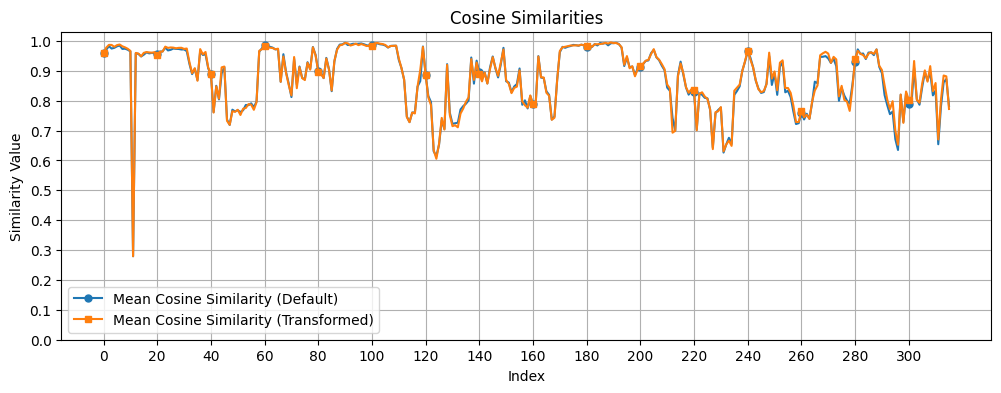

In [63]:
# Создание графика
plt.figure(figsize=(12, 4))

# Определяем шаг для маркеров
tick_interval = 20  # Интервал делений по оси X

# Создаем массив индексов, где будут отображаться маркеры
markevery_indices = np.arange(0, len(mean_cossims_default), tick_interval)

# Добавление линий для каждого списка с маркерами на нужных индексах
plt.plot(mean_cossims_default, label='Mean Cosine Similarity (Default)',
         marker='o', markersize=5, markevery=markevery_indices)
plt.plot(mean_cossims_transformed, label='Mean Cosine Similarity (Transformed)',
         marker='s', markersize=5, markevery=markevery_indices)

# Настройка графика
plt.title('Cosine Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity Value')

# Настройка меток по оси X (каждые 20 значений)
plt.xticks(
    ticks=np.arange(0, 316, step=20),
    labels=np.arange(0, 316, step=20)
    )

# Настройка делений по оси Y (от 0 до 1 с шагом 0.1)
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.legend()  # Отображение легенды
plt.grid()  # Включение сетки

# Показать график
plt.show()

In [65]:
print(f'Mean cossim (default):     {np.mean(mean_cossims_default):.4f}')
print(f'Mean cossim (transformed): {np.mean(mean_cossims_transformed):.4f}')

Mean cossim (default):     0.8791
Mean cossim (transformed): 0.8809


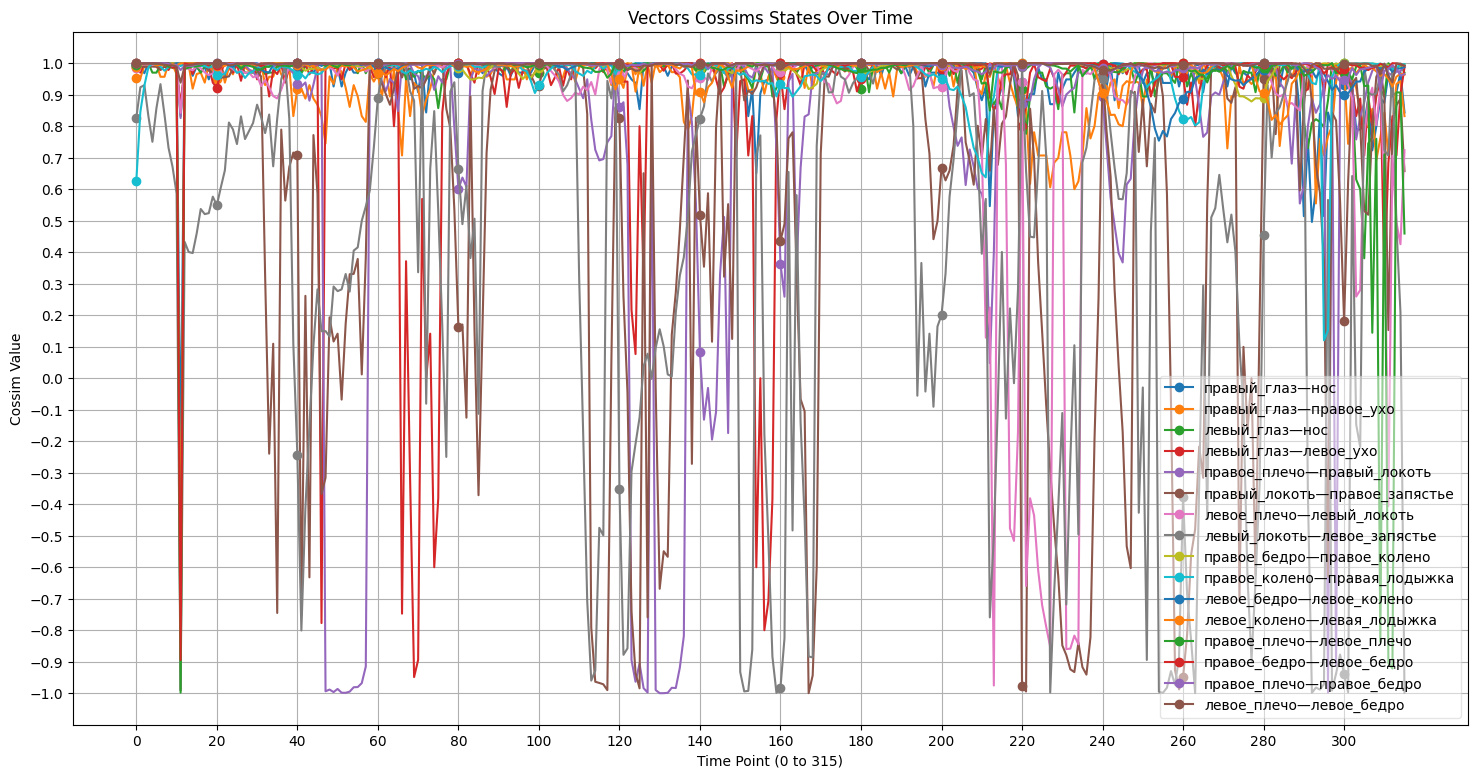

In [74]:
# Преобразуем список списков в NumPy массив для удобства
cossims_array = np.array(vecs_cossims_lists)

# Установка числа датчиков
num_sensors = cossims_array.shape[1]  # 16 точек
time_points = cossims_array.shape[0]  # Количество временных точек
# Список "имён векторов", составленных из конечных точек
vecs_names = [
    "правый_глаз—нос", "правый_глаз—правое_ухо",
    "левый_глаз—нос", "левый_глаз—левое_ухо",
    "правое_плечо—правый_локоть", "правый_локоть—правое_запястье",
    "левое_плечо—левый_локоть", "левый_локоть—левое_запястье",
    "правое_бедро—правое_колено", "правое_колено—правая_лодыжка",
    "левое_бедро—левое_колено", "левое_колено—левая_лодыжка",
    "правое_плечо—левое_плечо", "правое_бедро—левое_бедро",
    "правое_плечо—правое_бедро", "левое_плечо—левое_бедро"
]

# Создание графика
plt.figure(figsize=(18, 9))

# Определяем шаг для маркеров
tick_interval = 20  # Интервал делений по оси X

# Проходим по каждому датчику и отображаем его данные на графике
for sensor_idx in range(num_sensors):
    # Создаем список индексов, где будут отображаться маркеры
    markevery_indices = np.arange(0, time_points, tick_interval)
    plt.plot(
        cossims_array[:, sensor_idx], marker='o',
        markevery=markevery_indices,
        label=f'{vecs_names[sensor_idx]}'
        )

# Настройка графика
plt.title('Vectors Cossims States Over Time')
plt.xlabel('Time Point (0 to {})'.format(time_points - 1))
plt.ylabel('Cossim Value')
plt.xticks(
    ticks=np.arange(0, time_points + 1, 20),
    labels=np.arange(0, time_points + 1, 20)
    )  
plt.yticks(np.arange(-1, 1.1, step=0.1))
plt.legend(loc='lower right', framealpha=0.5)
plt.grid()
plt.show()

Какие-то ошибки всё же регулярны. Но мы и не можем расчитывать на совершенную синхронность в любительских танцах.

In [69]:
# Создание словаря с ключами из vecs_names и пустыми списками
cossims_dict = {name: [] for name in vecs_names}

# Заполнение словаря значениями из cossims_lists
for cossims in vecs_cossims_lists:
    for idx, value in enumerate(cossims):
        cossims_dict[vecs_names[idx]].append(value)

# Выведем сводку по метрикам каждого вектора
pd.DataFrame(cossims_dict).describe().T

,count,mean,std,min,25%,50%,75%,max
правый_глаз—нос,316.0,0.956518,0.100664,-0.263117,0.960000,0.989949,0.994692,1.0
правый_глаз—правое_ухо,316.0,0.927419,0.124139,-0.668268,0.919145,0.964764,0.990992,1.0
левый_глаз—нос,316.0,0.966871,0.062586,0.380750,0.968277,0.989949,0.995079,1.0
левый_глаз—левое_ухо,316.0,0.885467,0.325103,-0.948683,0.948683,0.978550,0.996729,1.0
правое_плечо—правый_локоть,316.0,0.736853,0.548450,-0.999907,0.824603,0.968018,0.996033,1.0
правый_локоть—правое_запястье,316.0,0.516784,0.619983,-0.999814,0.177364,0.826691,0.982831,1.0
левое_плечо—левый_локоть,316.0,0.872195,0.370566,-0.975568,0.945568,0.984918,0.996194,1.0
левый_локоть—левое_запястье,316.0,0.369233,0.652673,-1.000000,-0.061074,0.601235,0.929957,1.0
правое_бедро—правое_колено,316.0,0.988626,0.020314,0.878600,0.987942,0.996120,0.999308,1.0
правое_колено—правая_лодыжка,316.0,0.965830,0.084563,0.120331,0.965485,0.989409,0.997749,1.0


Есть ошибки в расположении предплечий: средние оценки и стандартные отклонения по векторам локоть-запястье говорят нам о том, что соответствие тут нарушается чаще всего.

In [93]:
frames_right_halves_folder = "right_halves"
frames_left_halves_folder = "left_halves"

# Получаем список файлов в папках
left_half_files = os.listdir(frames_left_halves_folder)[50:]
right_half_files = os.listdir(frames_right_halves_folder)[50:]

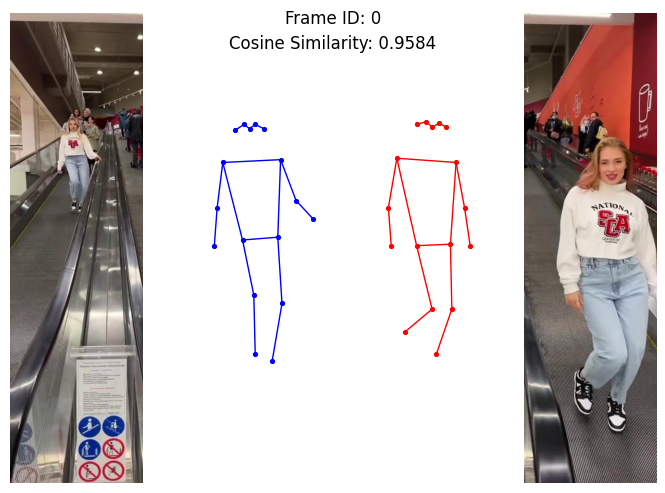

In [192]:
def visualize_frame(frame_id, scale_factor=1.2, figsize=(7, 5), return_img_byte_arr=False):
    # Получаем векторы для текущего кадра
    transformed_left_points = icp(
        left_half_kpts[frame_id][:, :2], right_half_kpts[frame_id][:, :2]
    )
    transformed_left_vectors = get_vectors(transformed_left_points, limbs)
    right_vectors = get_vectors(right_half_kpts[frame_id], limbs)

    # Вычисляем косинусную схожесть 
    mean_cossim, _, _, _ = cossim(right_vectors, transformed_left_vectors)

    # Создаем фигуру с 4 подграфиками 
    fig, axs = plt.subplots(1, 4, figsize=figsize)  # Увеличиваем размер фигуры 
    # Визуализация левого полукадра 
    left_part_path = os.path.join(frames_left_halves_folder, left_half_files[frame_id])
    left_half_image = plt.imread(left_part_path)
    axs[0].imshow(left_half_image)
    axs[0].axis('off')

    # Визуализация векторов для левого танцора
    show_vectors(np.array(transformed_left_vectors) * scale_factor, ax=axs[1])
    axs[1].axis('off')
    axs[1].invert_yaxis()

    # Визуализация векторов для правого танцора
    show_vectors(np.array(right_vectors) * scale_factor, ax=axs[2], color='r')
    axs[2].axis('off')
    axs[2].invert_yaxis()

    # Визуализация правого полукадра 
    right_part_path = os.path.join(frames_right_halves_folder, right_half_files[frame_id])
    right_half_image = plt.imread(right_part_path)
    axs[3].imshow(right_half_image)
    axs[3].axis('off')

    # Определяем пределы осей для векторов 
    all_vectors = np.concatenate([transformed_left_vectors, right_vectors], axis=0)
    # Увеличиваем пределы осей для учета масштабирования
    x_min, x_max = np.min(all_vectors[:, 0]), np.max(all_vectors[:, 0])
    y_min, y_max = np.min(all_vectors[:, 1]) - 10, np.max(all_vectors[:, 1]) + 70

    # Устанавливаем одинаковые пределы осей для подграфиков с векторами 
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_max, y_min)  # Инвертируем Y-оси
    axs[2].set_xlim(x_min, x_max)
    axs[2].set_ylim(y_max, y_min)  # Инвертируем Y-оси 

    # Добавление текста с ID кадра и метрикой косинусной схожести
    plt.figtext(0.5, 0.95, f'Frame ID: {frame_id}', ha='center', fontsize=12)
    plt.figtext(0.5, 0.9, f'Cosine Similarity: {mean_cossim:.4f}', ha='center', fontsize=12)

    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    
    if return_img_byte_arr:
        # Сохраняем изображение в BytesIO 
        img_byte_arr = BytesIO()
        plt.savefig(img_byte_arr, format='png', bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)  # Закрываем фигуру
        img_byte_arr.seek(0)  # Перемещаем указатель в начало

        # Открываем изображение из BytesIO и возвращаем его
        return Image.open(img_byte_arr)


# Вызов функции для визуализации кадра
visualize_frame(0)

In [ ]:
# Создание GIF
def create_gif(num_frames, gif_filename='output.gif'):
    images = []
    for frame_id in tqdm(range(0, num_frames, 3), desc="Processing frames"):
        img = visualize_frame(frame_id, return_img_byte_arr=True)
        images.append(img)

    # Создаем GIF из списка изображений 
    images[0].save(gif_filename, save_all=True, append_images=images[1:], loop=0, duration=3)
    
    print(f'GIF saved as {gif_filename}')

# Вызов функции для создания GIF
create_gif(num_frames=len(left_half_files), gif_filename='mediafiles/dancing_rtmo.gif')

Processing frames: 100%|██████████| 106/106 [00:32<00:00,  3.24it/s]


GIF saved as dance_animation.gif


![Animated GIF](mediafiles/dancing_rtmo.gif)